In [1]:
from pydub import AudioSegment # pip3 install pydub
import numpy as np
import scipy.signal

In [79]:
track_path = '40hz-beats.mp3'

In [80]:
# Butterworth band filter hepler

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = scipy.signal.butter(order, [low, high], btype='band')
    y = scipy.signal.lfilter(b, a, data)
    return y

In [81]:
#open track
track = AudioSegment.from_mp3(track_path)
frame_rate = track.frame_rate

#get samples from pydub to np.array
stereo_samples = np.array([ch.get_array_of_samples() for ch in track.split_to_mono()], dtype=np.float32)

#bandpass frequencies between 200Hz and 600Hz
filtered = [butter_bandpass_filter(chan, 200, 600, frame_rate)  for chan in stereo_samples]

#just multiply channels to emulate 
binaural_beats_emulation = filtered[0] * filtered[1]

In [82]:
#compute spectrogram

fftsize = 2 ** int(np.log2(frame_rate)+4)
f, t, Sxx = scipy.signal.spectrogram(binaural_beats_emulation, fs=track.frame_rate, nperseg=fftsize)

In [83]:
## Postproc

#get 0.5 - 50 Hz from beats
max_freq_ind = np.argmax(f>50)
min_freq_ind = np.argmin(f<0.5)
f = f[min_freq_ind:max_freq_ind+1]
Sxx = Sxx[min_freq_ind:max_freq_ind+1,:]

In [84]:
import matplotlib.pyplot as plt

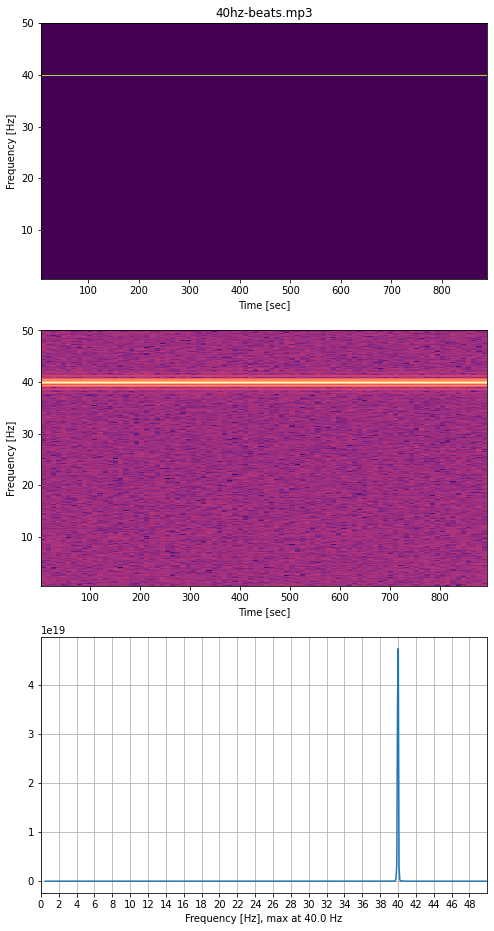

In [85]:
plt.close()
plt.figure(figsize=(8,16)) 
plt.subplot(311)
plt.pcolormesh(t, f, Sxx, shading='gouraud', vmax=Sxx.max())
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
#plt.title(f'{track_path} (linear scale)')
plt.title(f'{track_path}')

plt.subplot(312)
plt.pcolormesh(t, f, np.log2(Sxx+1.0), shading='auto', cmap='magma')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
#plt.title(f'{track_path} (log scale)')

plt.subplot(313)
plt.plot(f, Sxx.sum(1))
plt.axis(xmin=0, xmax=f.max().round())
plt.xlabel(f'Frequency [Hz], max at {f[Sxx.sum(1).argmax()].round(1)} Hz')
plt.xticks(np.arange(0, f.max().round(), 2))
plt.grid()

with open(track_path.replace('.mp3', '.png'), 'wb') as f:
    plt.savefig(f, format="png")
